In [1]:
import pandas as pd
import numpy as np
import math
import glob
import copy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

### Input Data
#### real - index: date, columns: real price of each ticker
#### pred - index: date, columns: pred price of each ticker

In [337]:
# Data loading and pre-processing
real = pd.read_csv("Real_Price_All_Tickers2.csv", index_col = "date")
pred = pd.read_csv("Predicted_Price_All_Tickers2.csv", index_col = "date")
# real.index = pd.to_datetime(real.index)
# pred.index = pd.to_datetime(pred.index)

# real dataset
real.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,79.137695,378.85,115.594800,174.49327,207.06,100.81135,269.93,102.16,64.390090,56.89,...,171.680,127.588356,170.17220,210.48,245.93,49.602440,199.380,68.79209,88.263490,96.39
2020-02-19,80.283830,383.28,120.781310,175.77339,210.76,100.00934,277.15,103.21,66.613500,58.90,...,183.484,129.425770,168.36691,211.23,247.78,49.803300,197.580,68.43440,89.717410,103.93
2020-02-20,79.460205,378.96,121.424750,175.30789,206.67,98.92712,272.49,102.54,65.615440,57.27,...,179.882,127.811960,168.01974,209.06,245.10,49.612003,190.560,68.31840,88.807470,105.29
2020-02-21,77.661620,372.95,119.679665,173.18407,201.91,98.27971,260.26,103.14,63.510605,53.28,...,180.200,124.944040,167.32541,206.12,246.29,49.210285,183.860,68.46340,86.760124,101.76
2020-02-24,73.972664,357.41,114.415160,169.26614,194.37,96.66603,240.11,99.02,60.358295,49.12,...,166.758,118.061030,166.22440,200.41,237.01,46.895634,177.105,68.02838,84.247920,105.01


In [338]:
# real dataset
pred.head(5)

,AAPL,ADBE,ADI,ADP,ADSK,AEP,ALGN,ALXN,AMAT,AMD,...,TSLA,TXN,VRSK,VRSN,VRTX,WBA,WDAY,XEL,XLNX,ZM
date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,80.238290,377.79680,114.141730,174.95505,207.90518,99.774070,273.59710,102.05196,65.529880,55.042230,...,159.20667,127.912285,169.20612,208.48730,242.59592,49.866670,195.92961,67.59191,88.742720,90.517990
2020-02-19,78.769090,376.98083,115.034300,173.68091,206.02470,100.322170,268.60175,101.65394,64.079120,56.614574,...,170.82222,126.973816,169.38383,209.39255,244.69531,49.364216,198.30661,68.45774,87.827446,95.932190
2020-02-20,79.909890,381.38898,120.195660,174.95510,209.70625,99.524055,275.78622,102.69873,66.291790,58.614845,...,182.56725,128.802370,167.58691,210.13869,246.53604,49.564100,196.51611,68.10180,89.274180,103.436424
2020-02-21,79.090096,377.09030,120.835976,174.49178,205.63670,98.447090,271.14914,102.03204,65.298540,56.992730,...,178.98330,127.196335,167.24135,207.97990,243.86946,49.373714,189.53366,67.98636,88.368740,104.790000
2020-02-24,77.299870,371.10995,119.099360,172.37784,200.90048,97.802830,258.97928,102.62906,63.203865,53.022040,...,179.29965,124.342220,166.55022,205.05507,245.05344,48.973920,182.86966,68.13066,86.331505,101.276794


In [360]:
# global parameters
short_tol = -0.001
long_num = 2
balance = 100000.0
pct = 0.1
long_only = False

pred_r = pred.pct_change()
total_days = real.shape[0] - 1

In [361]:
def DivideLongShort(total, pct):
    long_budget = total * pct
    short_margin = total - long_budget
    return long_budget, short_margin

def OrderBook(budget, candidates, costs, long=True):
#     print(candidates)
    if len(candidates) == 0:
        return {}
    orders = {ticker:0 for ticker in candidates}
    order_cost = 0
    ticker_budget = float(budget)/len(candidates)
    
    for i in range(len(candidates)):
        ticker = candidates[i]
        cost = costs[i]
        if long:
            orders[ticker] = int(ticker_budget/cost)
        else:
            orders[ticker] = int(ticker_budget/cost) * -1
        order_cost += orders[ticker] * cost
    
    return orders, order_cost

def UpdateBalance(prev_balance, long_orders, long_cost, short_orders, short_cost, real_prices):
    cur_balance = prev_balance - long_cost - short_cost
    for ticker in long_orders:
        cur_balance += long_orders[ticker] * real_prices[ticker]
    try:
        for ticker in short_orders:
            cur_balance += short_orders[ticker] * real_prices[ticker]
    except: pass
    return cur_balance

def DailyTrade(beg_balance, day, long_only=False):
    
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    short_tickers = daily_data[daily_data['pred_r'] <= short_tol]['ticker'].tolist()
    short_costs = daily_data[daily_data['pred_r'] <= short_tol]['cost'].tolist()
    long_tickers = daily_data.tail(long_num)['ticker'].tolist()
    long_costs = daily_data.tail(long_num)['cost'].tolist()
    
    if not long_only:

        long_budget, short_margin = DivideLongShort(beg_balance, pct)
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        short_orders, short_order_cost = OrderBook(short_margin, short_tickers, short_costs, False)
        real_prices = real.iloc[day + 1]

        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    short_orders, short_order_cost, real_prices)
    else:
        long_budget = beg_balance
        long_orders, long_order_cost = OrderBook(long_budget, long_tickers, long_costs)
        real_prices = real.iloc[day + 1]
        cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, \
                                    {}, 0, real_prices)
    
    return cur_balance

def DailyBenchmark(beg_balance, day):
    s_1 = pred_r.sort_values(list(real.index)[day + 1], axis=1).iloc[day + 1]
    daily_data = pd.DataFrame(data={'ticker': list(s_1.index), 'pred_r': list(s_1.values)})
    costs = pd.DataFrame(data={'ticker':list(real.iloc[day].index), 'cost':list(real.iloc[day].values)})
    daily_data = daily_data.merge(costs)

    long_tickers = daily_data['ticker'].tolist()
    long_costs = daily_data['cost'].tolist()
    long_orders, long_order_cost = OrderBook(beg_balance, long_tickers, long_costs)
    real_prices = real.iloc[day + 1]

    cur_balance = UpdateBalance(beg_balance, long_orders, long_order_cost, {}, 0, real_prices)
    
    return cur_balance

In [362]:
tradebal = copy.copy(balance)
bmbal = copy.copy(balance)
benchmark = []
my_portfolio = []

for day in range(total_days):
    tradebal = DailyTrade(tradebal, day, long_only)
    my_portfolio.append(tradebal)
    bmbal = DailyBenchmark(bmbal, day)
    benchmark.append(bmbal)
    
r_my = []
for x, y in zip(my_portfolio[:-1], my_portfolio[1:]):
    r_my.append((y - x) / x)
    
r_bm = []
for x, y in zip(benchmark[:-1], benchmark[1:]):
    r_bm.append((y - x) / x)
    
r_my = np.array(r_my)
r_bm = np.array(r_bm)
sharpe = (r_my.mean() - r_bm.mean()) / (r_my - r_bm).std()

print('Benchmark final: ', bmbal)
print('My Portfolio final: ', tradebal)
print('Sharpe Ratio: ', sharpe)

Benchmark final:  149921.38011860033
My Portfolio final:  49979.15245099977
Sharpe Ratio:  -0.10908854542476448


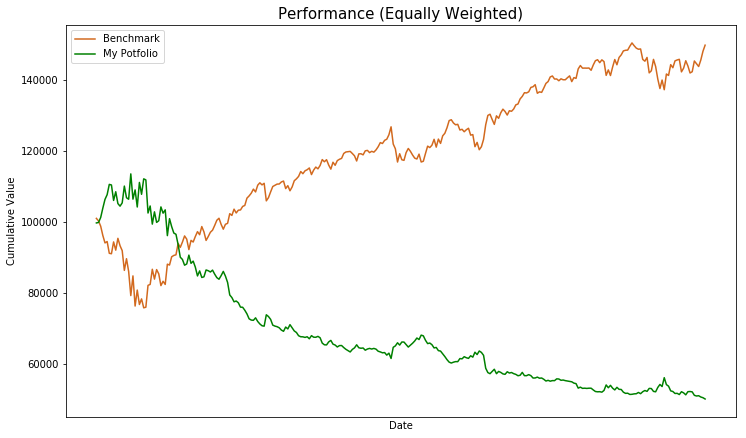

In [363]:
x = list(real.index)[:-1]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)  
ax.plot(x, benchmark, '-', color="chocolate", label='Benchmark')
ax.plot(x, my_portfolio, '-', color="green", label='My Potfolio')

# set xticks
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fmt_day = mdates.DayLocator()
ax.xaxis.set_minor_locator(fmt_day)
fig.autofmt_xdate()

plt.legend(loc='upper left')
plt.title("Performance (Equally Weighted)", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Cumulative Value")

plt.show()